Author: Nedal Mohammad

# Background and Context

Twitter possesses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other hand, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.


Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.

In this problem we will be looking at tweets about major U.S. airlines and perform sentiment analysis after cleaning the text data.

# Data Description

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

# Imports

Start by importing the libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


from wordcloud import WordCloud


from bs4 import BeautifulSoup


import re                         # Import Regex

!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import unicodedata
from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier       # Import Random forest Classifier
from sklearn.metrics import classification_report         # Import Classification report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nedal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nedal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nedal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Read and view the data:

In [2]:
data=pd.read_csv('Tweets.csv')

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


There are a lot of columns in this data set. The dataset is labelled so we can use a supervised learning method to tackle this challenge. In addition to the text and label, we have information about the tweet and the airline, which may be useful in EDA but not useful in modelling. 

The text provided for each tweet needs a lot of preprocessing to be done.

In [4]:
print('The data has', data.shape[0],'rows and', data.shape[1], 'columns')

The data has 14640 rows and 15 columns


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

The Sentiment and Text columns both have 0 missing values which is a good thing, as these will be used in modelling. Many of the other columns are missing data, which isn't a big deal as we don't actually need those aside from EDA.

In [6]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tweet_id,14640,NaN,NaN,NaN,5.69218e+17,7.79111e+14,5.67588e+17,5.68559e+17,5.69478e+17,5.6989e+17,5.70311e+17
airline_sentiment,14640,3,negative,9178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline_sentiment_confidence,14640,NaN,NaN,NaN,0.900169,0.16283,0.335,0.6923,1,1,1
negativereason,9178,10,Customer Service Issue,2910,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negativereason_confidence,10522,NaN,NaN,NaN,0.638298,0.33044,0,0.3606,0.6706,1,1
airline,14640,6,United,3822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline_sentiment_gold,40,3,negative,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,14640,7701,JetBlueNews,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negativereason_gold,32,13,Customer Service Issue,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retweet_count,14640,NaN,NaN,NaN,0.0826503,0.745778,0,0,0,0,44


We can see we are looking at tweets about 6 unique us airlines. The sentiment of most tweets is negative, with customer service issue as the most frequently occuring negatie issue. The tweets are coming from 85 unique timezones and 7,701 unique twitter users.

# Exploratory Data Analysis (EDA)

In [7]:
print('The unique airlines represented in the tweets are :', list(data['airline'].unique()))

The unique airlines represented in the tweets are : ['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American']


In [8]:
print('The unique values for airline sentiment are :', list(data['airline_sentiment'].unique()))

The unique values for airline sentiment are : ['neutral', 'positive', 'negative']


We can see that there are 6 airlines included in the data set. Each airline is given one sentiment per row in the dataset which is either positive, negative, or neutral.

Let's plot:
1. the distribution of tweets among each airline 
2. the distribution of sentiment across all tweets

<AxesSubplot:xlabel='airline', ylabel='Count'>

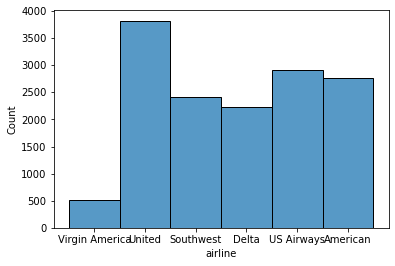

In [9]:
sns.histplot(data=data, x='airline', palette="winter")

We can see that a majority of the tweets regard the United airline while a minority regard Virgin America Airline. The other airlines are moderately represented.

<AxesSubplot:xlabel='airline_sentiment', ylabel='Count'>

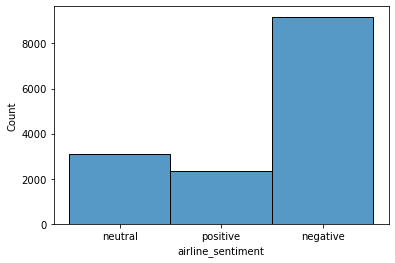

In [10]:
sns.histplot(data=data, x='airline_sentiment', palette="winter") #creating the histogram

Most tweets are made to portray negative sentiment. This makes sense because people don't usually go out of their way to say something went well, unless the experience completely exceeded expectations.

Let's look more closely at each airline. We can plot:

1. the distribution of sentiment of tweets for each individual airline
2. plot the distribution of all the negative reasons

In [11]:
#lets create subsets of the data, one for only positive reviews and the other for only negative reviews
only_negative = data[data['airline_sentiment'] == 'negative']
only_positive = data[data['airline_sentiment'] == 'positive']

#Let's also look at the unique negative reasons provided
only_negative['negativereason'].unique()

array(['Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems',
       'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

#### First we will look at Virgin America Airlines:

<AxesSubplot:xlabel='airline_sentiment', ylabel='Count'>

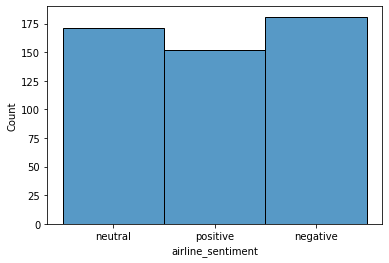

In [12]:
sns.histplot(data=data[data['airline'] == 'Virgin America'], x='airline_sentiment', palette="winter")

The sentiments are uniformly distributed for this airline.

<AxesSubplot:xlabel='negativereason', ylabel='Count'>

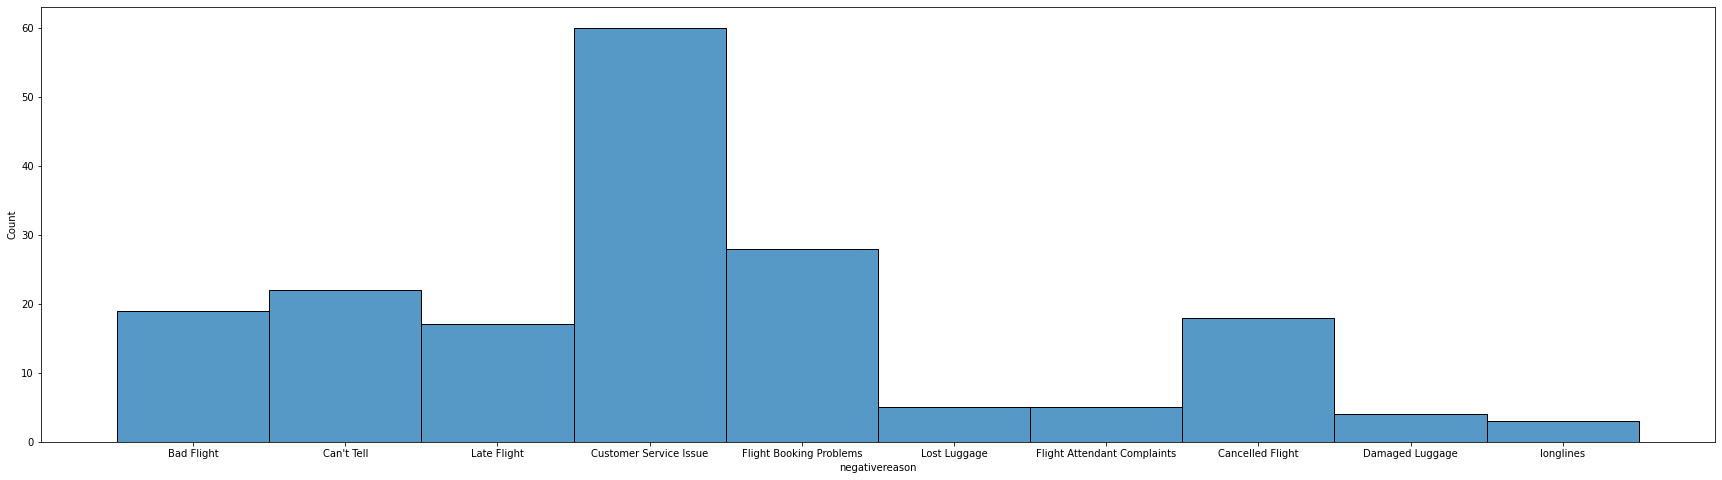

In [13]:
plt.figure(figsize=(30,8))
sns.histplot(data=only_negative[only_negative['airline'] == 'Virgin America'], x='negativereason', palette="winter")

The most frequent reason for negative sentiment is customer service, with honerable mentions from bad flight, cancelled flight, and flight booking problems. This airline doesn't appear to have many complaints about their flight attendants, the way they handle luggage, or the length of their lines.

#### Now we can look at United Airlines

<AxesSubplot:xlabel='airline_sentiment', ylabel='Count'>

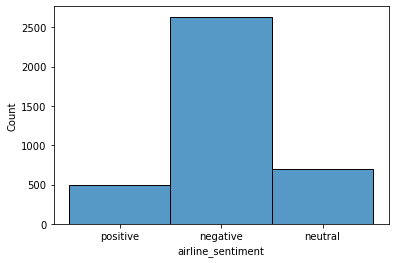

In [14]:
sns.histplot(data=data[data['airline'] == 'United'], x='airline_sentiment', palette="winter")

Negative sentiment is by far the most prevalent sentiment.

<AxesSubplot:xlabel='negativereason', ylabel='Count'>

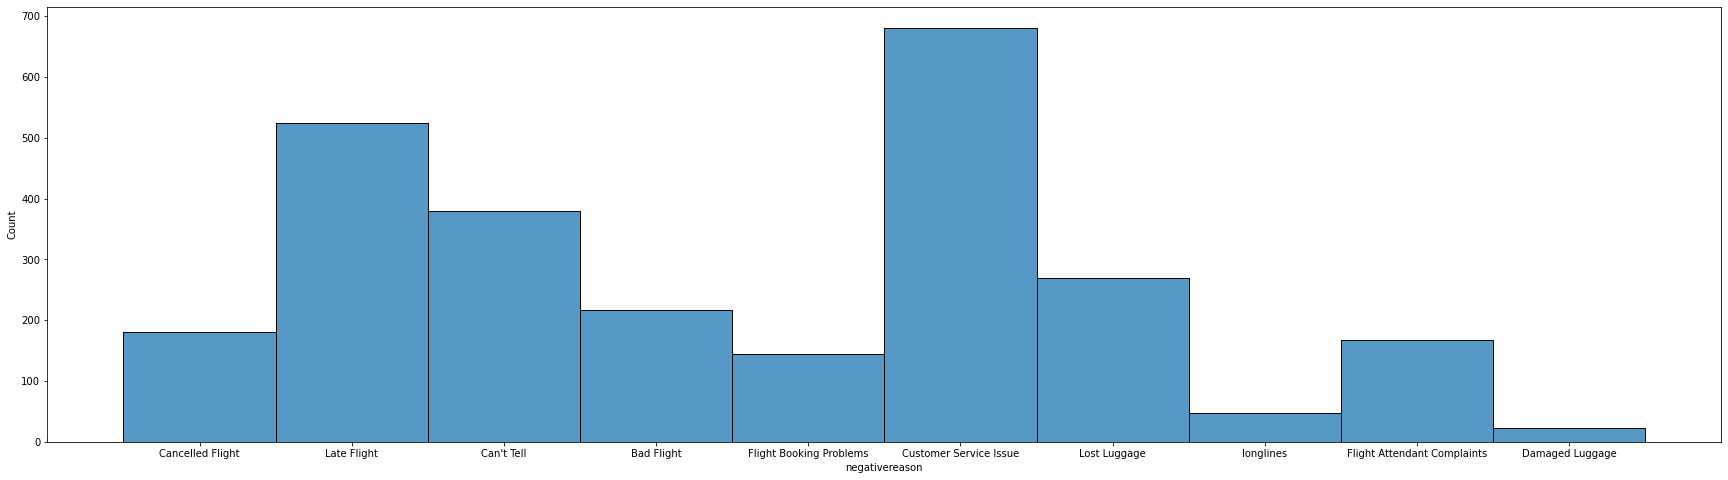

In [15]:
plt.figure(figsize=(30,8))
sns.histplot(data=only_negative[only_negative['airline'] == 'United'], x='negativereason', palette="winter")

The most frequent reason for negative sentiment is customer service, with honerable mentions from bad flight, late flight, flight attendants, and lost luggage. This airline doesn't appear to have many complaints about the length of their lines or damaged luggage. 

#### Now we can look at Southwest Airlines

<AxesSubplot:xlabel='airline_sentiment', ylabel='Count'>

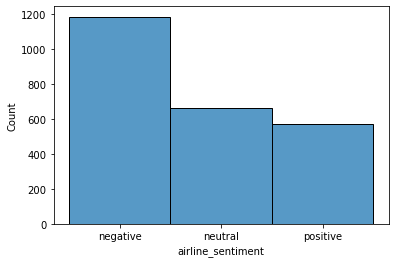

In [16]:
sns.histplot(data=data[data['airline'] == 'Southwest'], x='airline_sentiment', palette="winter")

Negative sentiment is by far the most prevalent sentiment.

<AxesSubplot:xlabel='negativereason', ylabel='Count'>

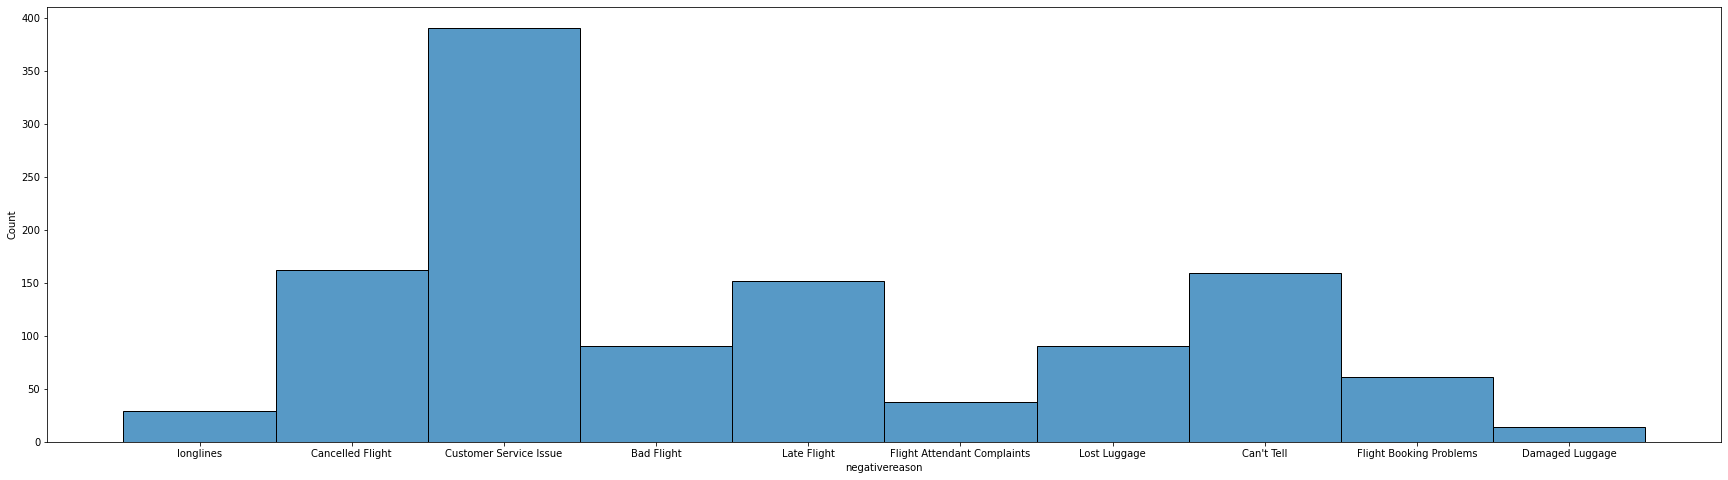

In [17]:
plt.figure(figsize=(30,8))
sns.histplot(data=only_negative[only_negative['airline'] == 'Southwest'], x='negativereason', palette="winter")

Customer service is once again the most frequent reason for negative sentiment. This airline also struggles with late/cancelled flights. There are not as many complaints regarding long lines, flight attendants, or damaged luggage.

#### Now we can look at Delta Airlines

<AxesSubplot:xlabel='airline_sentiment', ylabel='Count'>

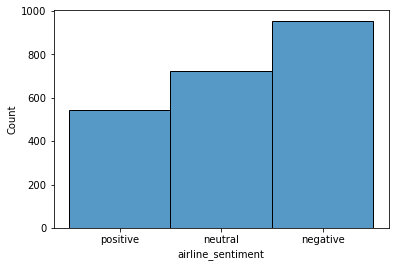

In [18]:
sns.histplot(data=data[data['airline'] == 'Delta'], x='airline_sentiment', palette="winter")

Negative sentiment is the most prevalent sentiment.

<AxesSubplot:xlabel='negativereason', ylabel='Count'>

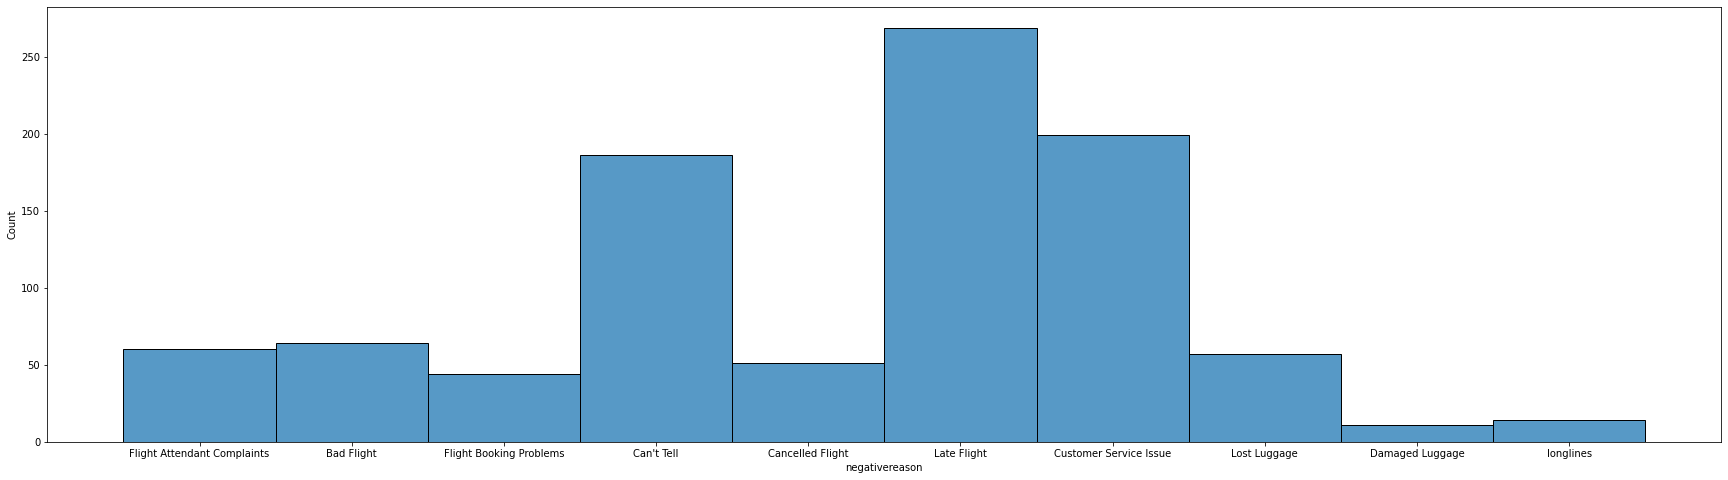

In [19]:
plt.figure(figsize=(30,8))
sns.histplot(data=only_negative[only_negative['airline'] == 'Delta'], x='negativereason', palette="winter")

The most frequent reason for negative sentiment is late flight,  this is closely followed by customer service. All other negative reason complaints are moderately represented.

#### Now we can look at US Airways airlines

<AxesSubplot:xlabel='airline_sentiment', ylabel='Count'>

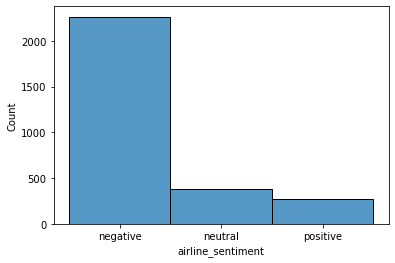

In [20]:
sns.histplot(data=data[data['airline'] == 'US Airways'], x='airline_sentiment', palette="winter")

Negative sentiment is by far the most prevalent sentiment.

<AxesSubplot:xlabel='negativereason', ylabel='Count'>

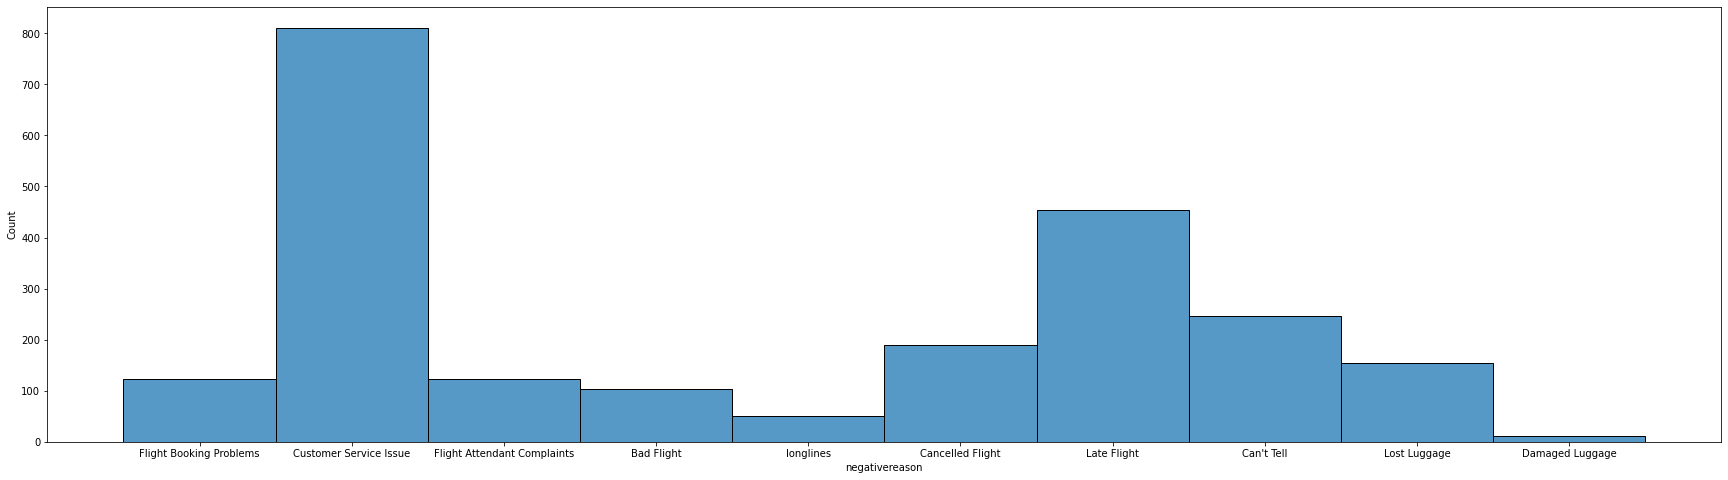

In [21]:
plt.figure(figsize=(30,8))
sns.histplot(data=only_negative[only_negative['airline'] == 'US Airways'], x='negativereason', palette="winter")

The most frequent reason for negative sentiment is customer service, this is closely followed by late flight. All other negative reason complaints are moderately represented, with only a few instances of damaged luggage and long lines.

#### Now we can look at American Airlines

<AxesSubplot:xlabel='airline_sentiment', ylabel='Count'>

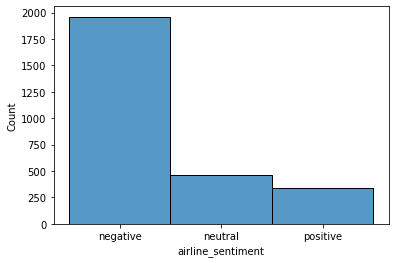

In [22]:
sns.histplot(data=data[data['airline'] == 'American'], x='airline_sentiment', palette="winter")

Negative sentiment is by far the most prevalent sentiment.

<AxesSubplot:xlabel='negativereason', ylabel='Count'>

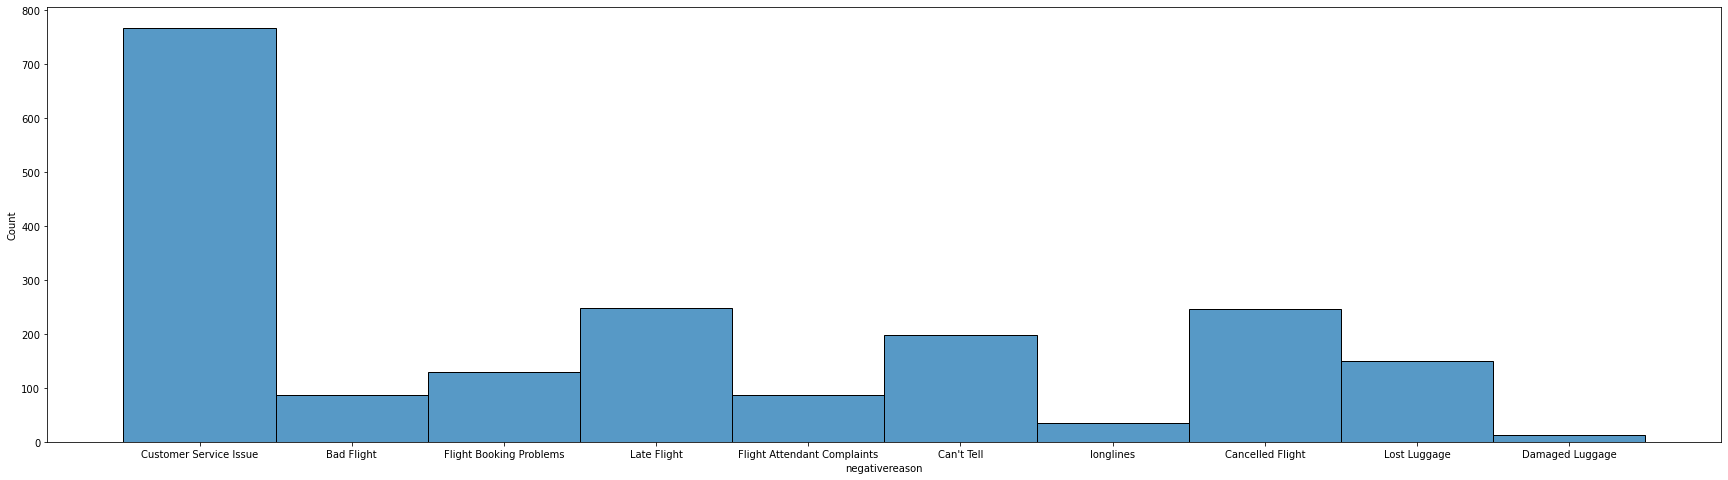

In [23]:
plt.figure(figsize=(30,8))
sns.histplot(data=only_negative[only_negative['airline'] == 'American'], x='negativereason', palette="winter")

The most frequent reason for negative sentiment is customer service, this is  followed by late/cancelled flight. All other negative reason complaints are moderately represented, with only a few instances of damaged luggage and long lines.

We can additionally look at the word cloud graphs for positive and negative sentiment tweets seperately:

In [24]:
def plotWords(words):
    wordcloud=WordCloud(width=1200, height=600, random_state=42,max_font_size=110).generate(words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis('off')
    plt.show()

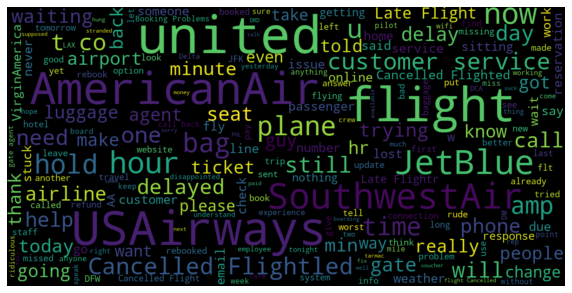

In [25]:
neg_words = only_negative.text.values.tolist()
neg_words = ' '.join(text for text in neg_words)
plotWords(neg_words)

Some words that stand out when looking at the word cloud for negative sentiment are : seat, bag, ticket, plane, time, called, refund, cancelled, people, phone, response, due, bag, line, website, stuck, staff

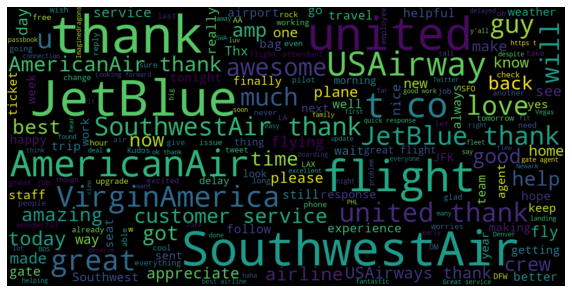

In [26]:
pos_words=only_positive.text.values.tolist()
pos_words=' '.join(text for text in pos_words)
plotWords(pos_words)

Some words that stand out when looking at the word cloud for positive sentiment are : love, thank, time, please, amazing, best, ticket, service, experience, crew, better, hope

# Prepare Data for Preprocessing

In [27]:
# let's look at a list of columns for reference when dropping in the next step
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [28]:
data.drop(['tweet_id', 'airline_sentiment_confidence','negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold','retweet_count', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],inplace=True, axis=1)
#dropping all columns except for airline_sentiment and text

In [29]:
data.columns

Index(['airline_sentiment', 'text'], dtype='object')

In [30]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [31]:
print('The revised data has', data.shape[0],'rows and', data.shape[1], 'columns')

The revised data has 14640 rows and 2 columns


#### printing the first 5 rows of data

In [32]:
for i in range(5):
    print(data['airline_sentiment'][i], '  ',data['text'][i])

neutral    @VirginAmerica What @dhepburn said.
positive    @VirginAmerica plus you've added commercials to the experience... tacky.
neutral    @VirginAmerica I didn't today... Must mean I need to take another trip!
negative    @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
negative    @VirginAmerica and it's a really big bad thing about it


We can immediately see that some of the labels are not appropriate --- for instance the tweet "plus you've added commercials to the experience... tacky." is categorized as positive sentiment however it would seem to carry negative sentiment to me. 

# Text Pre-Processing

1. Html tag removal.
2. Tokenization.
3. Remove the numbers.
4. Removal of Special Characters and Punctuations.
5. Removal of stopwords
6. Conversion to lowercase.
7. Lemmatize or stemming.
8. Join the words in the list to convert back to text string in the data frame. (So that each row contains the data in text format.)

In [33]:
pd.set_option('display.max_colwidth', None)
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


#### Let's write a function to perform each step of our preprocessing
#### Starting with HTML tag removal

In [34]:
#remove the html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()


data['text'] = data['text'].apply(lambda x: strip_html(x))


In [35]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


No HTML tags were present so no change is seen here.

#### Let's remove any URLs that may be in the tweets

In [36]:
# remove the url's present in the text
def remove_url(text): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
    return text
data['text'] = data['text'].apply(lambda x: remove_url(x))
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


#### Let's remove contractions here also before tokenizing

In [37]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [38]:
def cont_to_exp(x):
    for key in contractions:
        value=contractions[key]
        x=x.replace(key,value)
    return x


data['text'] = data['text'].apply(lambda x: cont_to_exp(x))
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


#### Remove numbers from the text

In [39]:
#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

data['text'] = data['text'].apply(lambda x: remove_numbers(x))
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


#### Remove mentions from the tweets

In [40]:
# remove the mentions in the tweets
def remove_mention(text):
    text = re.sub(r'@\w+','',text)
    return text
data['text'] = data['text'].apply(lambda x: remove_mention(x))
data.head()

,airline_sentiment,text
0,neutral,What said.
1,positive,plus you have added commercials to the experience... tacky.
2,neutral,I did not today... Must mean I need to take another trip!
3,negative,"it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,and it is a really big bad thing about it


#### tokenize

In [41]:
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data
data.head(10)

,airline_sentiment,text
0,neutral,"[What, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"
5,negative,"[seriously, would, pay, $, a, flight, for, seats, that, did, not, have, this, playing, ., it, is, really, the, only, bad, thing, about, flying, VA]"
6,positive,"[yes, ,, nearly, every, time, I, fly, VX, this, “, ear, worm, ”, won, ’, t, go, away, :, )]"
7,neutral,"[Really, missed, a, prime, opportunity, for, Men, Without, Hats, parody, ,, there, .]"
8,positive,"[Well, ,, I, did, not…but, NOW, I, DO, !, :, -D]"
9,positive,"[it, was, amazing, ,, and, arrived, an, hour, early, ., You, 're, too, good, to, me, .]"


#### remove non ascii characters

In [42]:
#remove the non-ASCII characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
data['text']=data['text'].apply(lambda x: remove_non_ascii(x))
data.head()

,airline_sentiment,text
0,neutral,"[What, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


#### Convert to lowercase

In [43]:
# convert all characters to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
data['text']=data['text'].apply(lambda x: to_lowercase(x))
data.head()

,airline_sentiment,text
0,neutral,"[what, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[i, did, not, today, ..., must, mean, i, need, to, take, another, trip, !]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


#### Remove hash tags

In [44]:
# Remove the hashtags
def remove_hash(words):
    """Remove hashtags from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'#\w+','',word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

data['text']=data['text'].apply(lambda x: remove_hash(x))
data.head()

,airline_sentiment,text
0,neutral,"[what, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[i, did, not, today, ..., must, mean, i, need, to, take, another, trip, !]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


#### Remove punctuation

In [45]:
# Remove the punctuations
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

data['text']=data['text'].apply(lambda x: remove_punctuation(x))
data.head()

,airline_sentiment,text
0,neutral,"[what, said]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, tacky]"
2,neutral,"[i, did, not, today, must, mean, i, need, to, take, another, trip]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


#### Remove stopwords

In [46]:
stopwords = stopwords.words('english')
stopwords = list(set(stopwords)) 


# Remove the stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

data['text']=data['text'].apply(lambda x: remove_stopwords(x))
data.head()

,airline_sentiment,text
0,neutral,[said]
1,positive,"[plus, added, commercials, experience, tacky]"
2,neutral,"[today, must, mean, need, take, another, trip]"
3,negative,"[really, aggressive, blast, obnoxious, entertainment, guests, faces, little, recourse]"
4,negative,"[really, big, bad, thing]"


#### Lemmatize the words

In [47]:
lemmatizer = WordNetLemmatizer()
# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

data['text']=data['text'].apply(lambda x: lemmatize_list(x))
data.head()

,airline_sentiment,text
0,neutral,[say]
1,positive,"[plus, add, commercials, experience, tacky]"
2,neutral,"[today, must, mean, need, take, another, trip]"
3,negative,"[really, aggressive, blast, obnoxious, entertainment, guests, face, little, recourse]"
4,negative,"[really, big, bad, thing]"


Now the data should be ready, let's take one last look at the first 10 rows.

In [48]:
def normalize(words):
    return ' '.join(words) #take the words out of the list and use space as a delimiter
data['text']=data['text'].apply(lambda x: normalize(x))
data.head()

,airline_sentiment,text
0,neutral,say
1,positive,plus add commercials experience tacky
2,neutral,today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainment guests face little recourse
4,negative,really big bad thing


In [49]:
data.head(10)

,airline_sentiment,text
0,neutral,say
1,positive,plus add commercials experience tacky
2,neutral,today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainment guests face little recourse
4,negative,really big bad thing
5,negative,seriously would pay flight seat play really bad thing fly va
6,positive,yes nearly every time fly vx ear worm go away
7,neutral,really miss prime opportunity men without hat parody
8,positive,well notbut
9,positive,amaze arrive hour early good


Now that we have preprocessed all of the text data, we can begin modeling.

# Supervised Learning for Sentiment Analysis

### Bag of Words (CountVectorizer)

In BoW, we construct a dictionary that contains the set of all unique words from our text review dataset. The frequency of the word is counted here. If there are d unique words in our dictionary then for every review the vector will be of length d and count of word from reviews is stored at its particular location in vector. The vector will be highly sparse in such cases.

In [50]:
# Vectorization (Convert text data to numbers).


Count_vec = CountVectorizer(max_features=1000)        # Keep only 1000 features as number of features will increase the processing time.
data_features = Count_vec.fit_transform(data['text'])

data_features = data_features.toarray()                # Convert the data features to array.

In [51]:
data_features.shape       #Shape of the feature vector

(14640, 1000)

In [52]:
X = data_features

y = data['airline_sentiment']

In [53]:
# Split data into training and testing set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

Using k fold cross validation to determine an optimal number of base learners in a random forest classifier model that will recieve the count vectorizer matrix as input.

In [54]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [55]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

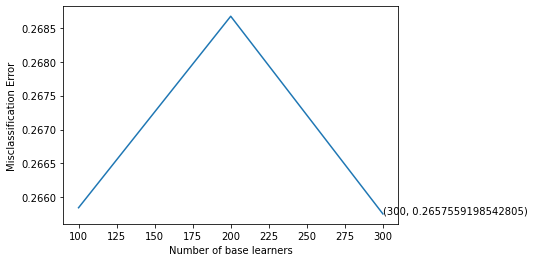

In [56]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

For CountVectorizer, the error was at a minimum when there were 100 base learners in the random forest.

In [57]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
count_vectorizer_predicted = clf.predict(X_test)
print(classification_report(y_test ,count_vectorizer_predicted , target_names = ['negative' , 'neutral','positive']))
print("Accuracy of the model is : ",accuracy_score(y_test,count_vectorizer_predicted))

              precision    recall  f1-score   support

    negative       0.86      0.87      0.87      2627
     neutral       0.48      0.45      0.47       577
    positive       0.63      0.65      0.64       456

    accuracy                           0.78      3660
   macro avg       0.66      0.66      0.66      3660
weighted avg       0.77      0.78      0.78      3660

Accuracy of the model is :  0.7775956284153005


78% accuracy really isn't bad. We can see that the model actually performs well in identifying negative sentiment. It performs okay in determining positive sentiment, and poorly in determining neutral sentiment.

[[2289  231  107]
 [ 249  262   66]
 [ 111   50  295]]


<AxesSubplot:>

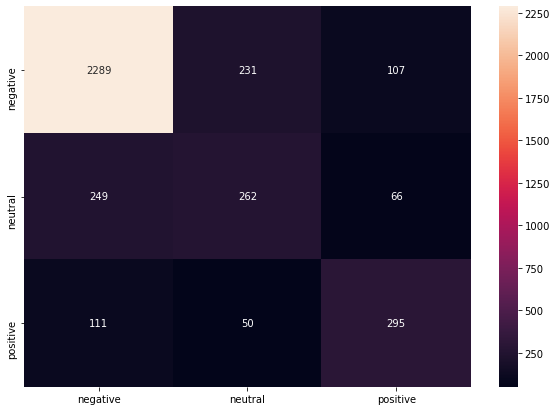

In [58]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.



conf_mat = confusion_matrix(y_test, count_vectorizer_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['negative' , 'neutral','positive']],
                  columns = [i for i in ['negative' , 'neutral','positive']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

The vertical axis represents the true values while the horizontal axis represents the predicted values. 
We can see that negative reviews are predicted the best, this is probably because most of the training points were negative reviews. The bag of words model is only using the most occuring 1000 words to make predictions, so if most of the reviews were negative it makes sense that it would cater towards the imbalance by learning more from the negative sentiment datapoints. We can actually look at the top 40 words just to see which kinds of words it has picked up on. We can even make a word cloud.

thank,delay,great,flight,love,hours,hold,awesome,bag,get,hour,cancel,best,amaze,wait,worst,fly,would,time,please,service,make,customer,plane,call,fleek,help,go,need,never,still,lose,say,fleet,miss,luggage,try,good,tell,know,
 
 


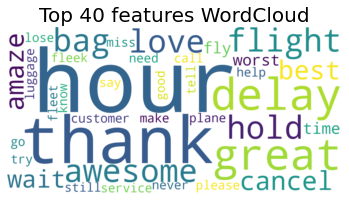

In [59]:
all_features = Count_vec.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=','
    
print(top_features)  

print(" ") 
print(" ")     

wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

## TF-IDF

Term Frequency - Inverse Document Frequency: It makes sure that less importance is given to the most frequent words, and it also considers less frequent words.

In [60]:
# Using TfidfVectorizer to convert text data to numbers.
tfidf_vect = TfidfVectorizer(max_features=1000)
data_features = tfidf_vect.fit_transform(data['text'])

data_features = data_features.toarray()

data_features.shape     #feature shape

(14640, 1000)

In [61]:
X = data_features

y = data['airline_sentiment']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

Using k fold cross validation to determine an optimal number of base learners in a random forest classifier model that will recieve the tf-idf matrix as input.

In [63]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [64]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

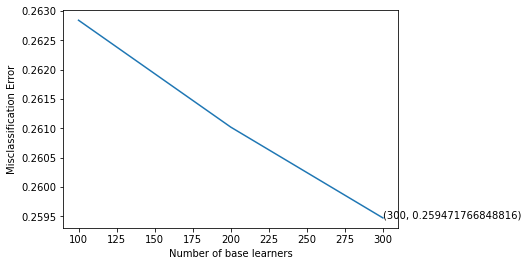

In [65]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

For tf-idf vectorizer, the error was at a minimum when there were 200 base learners in the random forest.

In [66]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
tf_idf_predicted = clf.predict(X_test)
print(classification_report(y_test , tf_idf_predicted , target_names = ['negative' , 'neutral','positive']))
print("Accuracy of the model is : ",accuracy_score(y_test,tf_idf_predicted))

              precision    recall  f1-score   support

    negative       0.86      0.91      0.88      2627
     neutral       0.57      0.44      0.49       577
    positive       0.70      0.64      0.67       456

    accuracy                           0.80      3660
   macro avg       0.71      0.66      0.68      3660
weighted avg       0.79      0.80      0.79      3660

Accuracy of the model is :  0.8027322404371585


The accuracy of the model has improved from 77.8% to 88.1%

Performance was all around better, however the model is still notably better at classifying the negative tweets then the neutral or positive ones. 

[[2395  162   70]
 [ 271  253   53]
 [ 134   32  290]]


<AxesSubplot:>

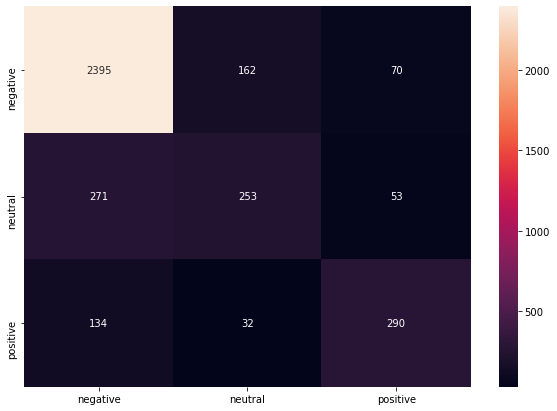

In [67]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
conf_mat = confusion_matrix(y_test, tf_idf_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['negative' , 'neutral','positive']],
                  columns = [i for i in ['negative' , 'neutral','positive']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

The vertical axis represents the true values while the horizontal axis represents the predicted values. 

We can see that negative reviews are predicted the best, this is probably once again because most of the training points were negative reviews. A large portion of positive/neutral reviews are being classified as negative.

We can create the top 40 features words cloud

thank, great, delay, flight, love, hold, get, hours, awesome, bag, cancel, best, amaze, fly, service, fleek, hour, please, time, wait, need, fleet, plane, make, would, follow, call, customer, good, dm, worst, help, know, tomorrow, airline, lose, say, never, still, go, 
 
 


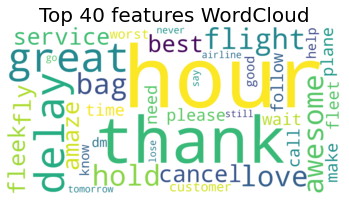

In [68]:
all_features = tfidf_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=', '
    
print(top_features)  

print(" ") 
print(" ") 

wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

We notice that the top 40 words are comparable between the two alogorithms, many of them the same.

Let's compare the two vectorizers more closely:

In [69]:
#convert the test samples into a dataframe where the columns are
#the y_test(ground truth labels),tf-idf model predicted labels(tf_idf_predicted),Count Vectorizer model predicted labels(count_vectorizer_predicted)
df = pd.DataFrame(y_test.tolist(),columns =['y_test'])
df['count_vectorizer_predicted'] = count_vectorizer_predicted
df['tf_idf_predicted'] = tf_idf_predicted
df.head()

,y_test,count_vectorizer_predicted,tf_idf_predicted
0,negative,negative,negative
1,negative,negative,negative
2,negative,negative,negative
3,negative,neutral,negative
4,positive,positive,positive


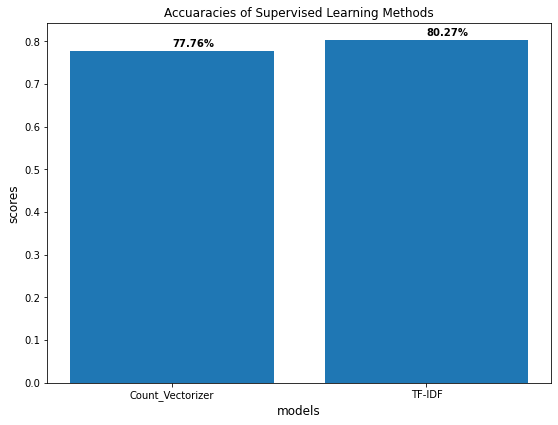

In [70]:
#create bar plot to compare the accuaracies of Count Vectorizer and TF-IDF

fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
subjects = ['Count_Vectorizer', 'TF-IDF']

# calculation accuracies of Count Vectorizer and TF-IDF using accuracy_score metrics
scores = [accuracy_score(y_test,count_vectorizer_predicted),accuracy_score(y_test,tf_idf_predicted)]
ax.bar(subjects,scores)
ax.set_ylabel('scores',fontsize= 12)    # y axis label
ax.set_xlabel('models',fontsize= 12)    # x axis label
ax.set_title('Accuaracies of Supervised Learning Methods')  # tittle
for i, v in enumerate(scores):
    ax.text( i ,v+0.01, '{:.2f}%'.format(100*v), color='black', fontweight='bold')     
    plt.savefig('barplot_1.png',dpi=100, format='png', bbox_inches='tight')
plt.show()

We can see that tf-idf was able to outperform the CountVectorizer by about 2%. We can try tuning the hyperparameters of the underlying randomforest model.

In [96]:
# Choose the type of classifier. 
rf_estimator = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {  
        "n_estimators": np.arange(100,400,100),
        "max_features": [0.5,0.75,"log2"]
}



# Run the grid search
grid_obj = GridSearchCV(rf_estimator, parameters, scoring='accuracy',cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_estimator.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', n_estimators=300, random_state=1)

We found that a max features of log2 and n_estimators of 300 we achieved the most accurate model.

In [97]:
rf_estimator.score(X_train, y_train)

0.9847905282331512

In [98]:
# Training the best model and calculating accuracy on test data .


rf_estimator.score(X_test, y_test)
rf_estimator_predicted = rf_estimator.predict(X_test)
print(classification_report(y_test , rf_estimator_predicted , target_names = ['negative' , 'neutral','positive']))
print("Accuracy of the model is : ",accuracy_score(y_test,rf_estimator_predicted))

              precision    recall  f1-score   support

    negative       0.85      0.93      0.89      2627
     neutral       0.58      0.42      0.48       577
    positive       0.75      0.58      0.65       456

    accuracy                           0.81      3660
   macro avg       0.72      0.64      0.67      3660
weighted avg       0.79      0.81      0.79      3660

Accuracy of the model is :  0.8051912568306011


[[2441  139   47]
 [ 293  241   43]
 [ 154   37  265]]


<AxesSubplot:>

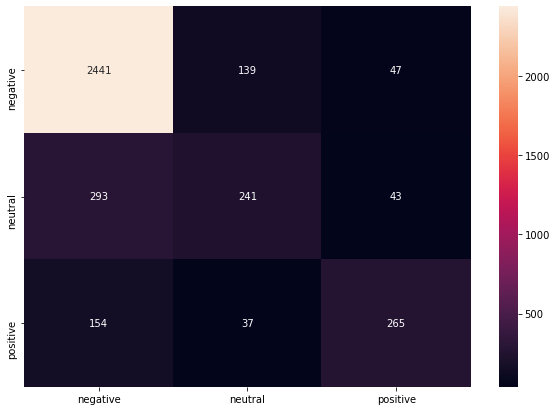

In [99]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
conf_mat = confusion_matrix(y_test, rf_estimator_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['negative' , 'neutral','positive']],
                  columns = [i for i in ['negative' , 'neutral','positive']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

Looking at the confusion matrix, we see some additional correct classifications for the neutral and negative classes, however the model is performing worse on positive classifications. Because the negative class is more important I still think this is an improvement.

# Conclusions and Scope of Improvement

## Conclusions
We were able to preprocess the data into a state that it would be useful for the vectorizers. This included a lot of cleaning and then lemmatization which resulted in a clean dataset, free of stop words, punctuation, URLS, HTML tags, special characters,  and twitter handles. This was fed into 2 seperate vectorizers. 

The two vectorizers used were CountVectorizer, which functions as a bag of words, and tf-idf vectorizer which functions similarly but also takes into account the frequency of a specific word across all documents. We determined that the best performance resulted from the TF-IDF vectorizer, which had a 2% accuracy improvement.

Then we went on to tune the random forest operating on the tf-idf vectorized input. Tuning the random forest resulted in only slight improvements to the final classification, and took many hours to train. After trying to tune the random forest, the model actually performed worse when trying to classify positive sentiment. I think negative sentiment is more important to catch personally so i don't think this is a bad thing. I think the best way to improve scores for positive sentiment is to collect more training points, or correct some of the bad labels in the data. One thing that could be changed is to reduce the number of classes from 3 to 2, so that the neutral sentiment points were lumped together with the positive sentiment data points.


## Scope of Improvement

More analysis could have been done on this project in general, Unsupervised methods could have been employed for sentiment analysis such as vader, but since our data was labelled we took the supervised route.

Some more powerful vectorizers could have been used such as word2vec, which I believe would have improved the accuracy of the models. This vectorizer would result in the computer understanding the relationships between words instead of just term frequencies.

No research was done to find pretrained models which may have been employed against this problem, so that is also a possibility.

Thanks!